In [1]:
%matplotlib inline

import os

import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../../..')

%load_ext autoreload
%autoreload 2

from computer_vision.yolov11.modules.detector import DetectionModel
from computer_vision.yolov11.parameter_parser import parser
from computer_vision.yolov11.utils.check import check_imgsz
from computer_vision.yolov11.data.utils import get_image_files
from computer_vision.yolov11.data.dataset import YOLODataset

In [3]:
data_dirpath=r'D:/data/ultralytics/coco128'

argument=f'''--root {data_dirpath} --image-dirname images/train2017 --label-dirname labels/train2017
--data-cfg ../coco128.yaml --hyperparam ../default.yaml '''
args=parser.parse_args(argument.split())

In [4]:
model=DetectionModel(cfg='../yolo11.yaml', ch=3)
print('stride ', model.stride)
gs = max(int(model.stride.max() if hasattr(model, "stride") else 32), 32)  # grid size (max stride)
print('grid size ', gs)
check_imgsz(args.imgsz, stride=gs, floor=gs, max_dim=1) # args.imgsz 

In BaseModel._predict_once max_idx -1 embed {-1}
stride  tensor([ 8., 16., 32.])
grid size  32


640

In [5]:
dataset=YOLODataset(img_path=os.path.join(args.root, args.image_dirname),label_path=os.path.join(args.root, args.label_dirname),
                    data=args.data_cfg, hyp=args.hyperparam, imgsz=640, cache=True, augment=True, rect=False, batch_size=8, stride=32, pad=0.5, 
                    single_cls=False, classes=None, fraction=1., channels=3)

print('dataset.im_files ', len(dataset.im_files), len(dataset))

In data.dataset.YOLODataset.update_images_labels cache path D:\data\ultralytics\coco128\labels\train2017.cache exist. Load it!!!
Scanning D:\data\ultralytics\coco128\labels\train2017.cache ... 126 images with 2 missing and 0 empty files as well as 0 corrupt files
max_buffer_length  64  ni  128
dataset.im_files  128 128


## How do they deal with rect? 
It seems they don't.

In [10]:
dataloader=torch.utils.data.DataLoader(dataset=dataset, batch_size=3, shuffle=False, sampler=None, batch_sampler=None, 
                                       num_workers=0, collate_fn=YOLODataset.collate_fn, pin_memory=False, drop_last=True, 
                                       timeout=0, worker_init_fn=None, prefetch_factor=None, persistent_workers=False)
data=next(iter(dataloader))

In [11]:
data['ori_shape'], data['im_file'], data['resized_shape']

(((480, 640), (426, 640), (428, 640)),
 ('D:\\data\\ultralytics\\coco128\\images\\train2017\\000000000009.jpg',
  'D:\\data\\ultralytics\\coco128\\images\\train2017\\000000000025.jpg',
  'D:\\data\\ultralytics\\coco128\\images\\train2017\\000000000030.jpg'),
 ((640, 640), (640, 640), (640, 640)))

In [8]:
data['img'].shape, data['batch_idx'], data['bboxes'].shape, data['cls'].shape

(torch.Size([3, 3, 640, 640]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2.]))

In [9]:
data.keys()

dict_keys(['batch_idx', 'bboxes', 'cls', 'im_file', 'img', 'ori_shape', 'resized_shape'])

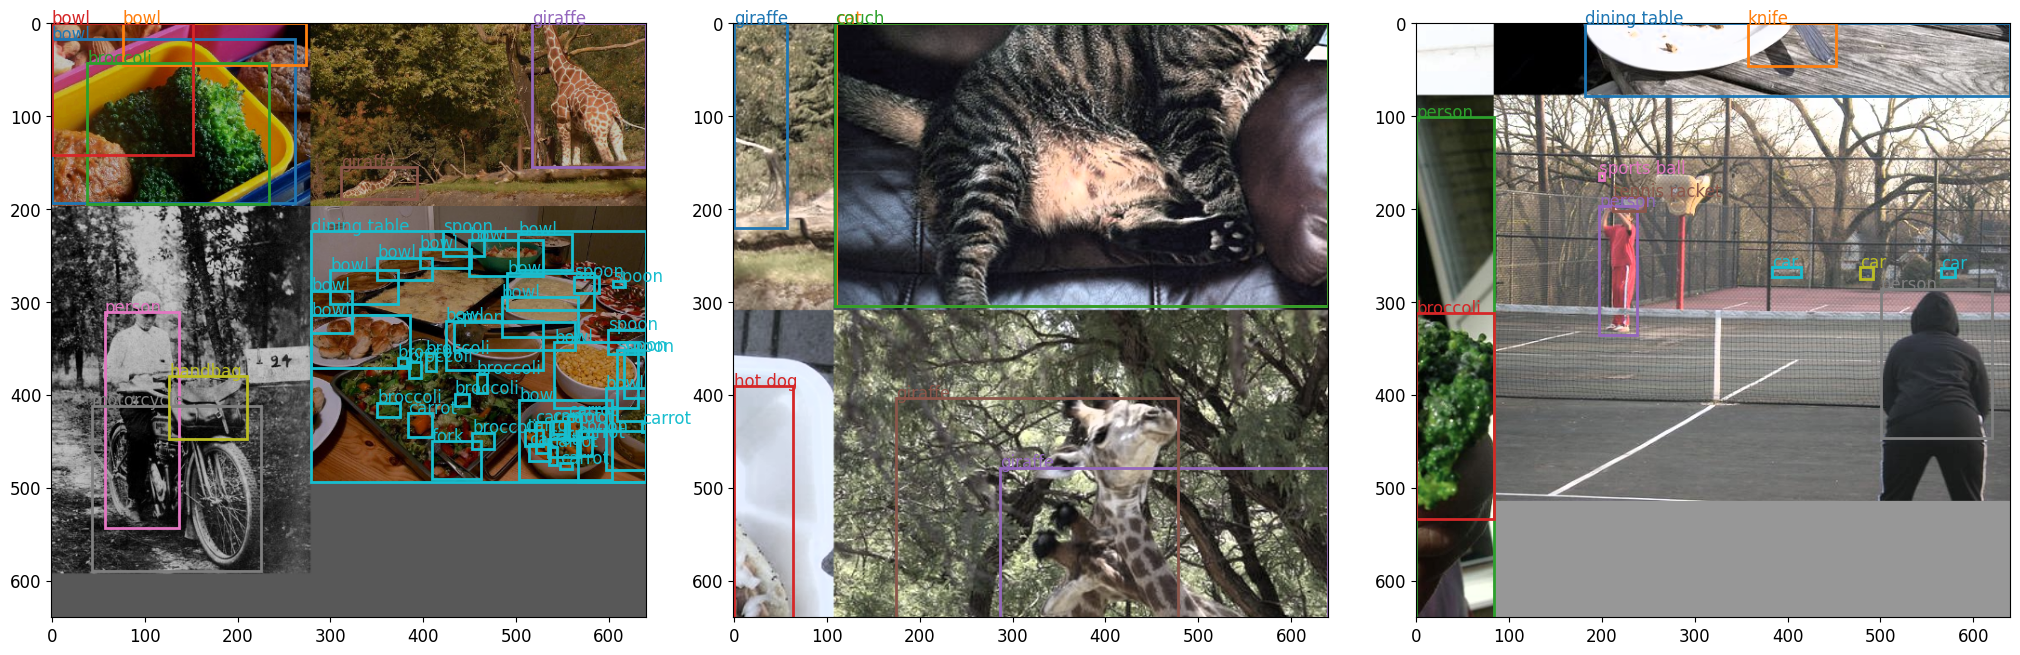

In [17]:
from computer_vision.yolov11.utils.ops import xywhn2xyxy, xywh2xyxy
from computer_vision.yolov11.data.utils import imread
from matplotlib import patches

cmap = plt.get_cmap('tab10', 10)
plt.rcParams.update({'font.size'   : 12})

_, ax=plt.subplots(1, data['img'].shape[0], figsize=(20,10))
for i, img in enumerate(data['img']):
    # image of size CxHxW
    selection_mask=data['batch_idx']==i
    cls=data['cls'][selection_mask]
    bboxes=(data['bboxes'][selection_mask]).numpy()
    h, w=img.shape[1:]
    img=img.permute(1,2,0).contiguous().numpy() # CxHxW to HxWxC
    boxes=xywhn2xyxy(bboxes, w=w, h=h)

    classes=[dataset.data['names'][int(c)] for c in cls.flatten()]
    
    ax[i].imshow(img)
    for j, (box,cls) in enumerate(zip(boxes, classes)):
        # Create a Rectangle patch
        rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
        # Add the patch to the Axes
        ax[i].add_patch(rect)
        ax[i].text(*box[:2], f'{cls}', color=cmap(j), fontsize=12)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)